In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import sparse
import statsmodels.tsa.stattools as sts
import statsmodels.api as sm
import copy

In [2]:
nloop=4000
burnin=1000
M=1000

In [3]:
data5=pd.read_csv('C:\\Users\\wuboyuan\\Desktop\\深成指数.csv',header=None)
data5=100*data5.apply(np.log).diff(1)[1:]
y=data5.T.values[0]
T=len(y)

# 先验分布参数

In [4]:
phih0=0.97
vphih=0.1**2
rhoh0=0
vrhoh=1
mu0=0
vmu=10
muh0=1
vmuh=10
nuh=5
sh=0.2**2*(nuh-1)

# 初始化马尔可夫链

In [5]:
muh=np.log(np.var(y))
phih=0.95
rhoh=0.0
omegah2=0.2**2
h=muh+np.sqrt(omegah2)*np.random.randn(T,1)
exph=np.exp(h)

# 存储空间

In [6]:
store_theta=np.zeros([nloop-burnin,5])
store_h =np.zeros([nloop - burnin,T])
store_q =np.zeros([nloop - burnin,2])

# 循环外的计算

In [7]:
hphi=np.eye(T)-sparse.coo_matrix((phih*np.ones(T-2),(np.arange(2,T),np.arange(1,T-1))),shape=(T,T))-sparse.coo_matrix((rhoh*np.ones(T-2),(np.arange(2,T),np.arange(0,T-2))),shape=(T,T))
newnuh=T/2+nuh
newnuh=T/2+nuh
counth=0
countphi=0

# MCMC

In [ ]:
for loop in range(nloop):
    invdmu=1/vmu+sum(1./exph)
    muhat=(invdmu**(-1))*(1/vmu*mu0+sum((np.matrix(y).T)/exph))
    mu=muhat+((np.linalg.cholesky(np.matrix(invdmu)).T)**(-1))*np.random.randn(1)

    intvar=(1-rhoh)*omegah2/((1+rhoh)*((1-rhoh)**2-phih**2))
    hish=hphi.T*sparse.coo_matrix((np.hstack(([float(1/intvar),float(1/intvar)],1/float(omegah2)*np.ones(T-2))),(np.arange(T),np.arange(T))),shape=(T,T))*hphi
    hishdeltah=hphi.T*sparse.coo_matrix((np.hstack(([float(1/intvar),float(1/intvar)],1/float(omegah2)*np.ones(T-2))),(np.arange(T),np.arange(T))),shape=(T,T))*np.vstack(([[float(muh)],[float(muh)]],np.ones([T-2,1])*(1-phih-rhoh)*muh))
    deltah=(hish**(-1))*hishdeltah
    s2=np.power((np.matrix(y).T-mu),2)
    errh=1
    ht=h

    while errh>10**(-3):
        expht=np.exp(ht)
        sinvexpht=s2/expht
        fh=-0.5+0.5*sinvexpht
        gh=0.5*sinvexpht
        kh=hish+sparse.coo_matrix((gh.T.tolist()[0],(np.arange(T),np.arange(T))),shape=(T,T))
        newht=kh**(-1)*(fh+np.multiply(gh,ht)+hishdeltah)
        errh=max(abs(newht-ht)).tolist()[0][0]
        ht=newht
    cholhh=np.linalg.cholesky(kh)

    lph=lambda x: -0.5*(x-deltah).T*hish*(x-deltah)-0.5*sum(x)-0.5*np.exp(-x).T*s2
    logc=lph(ht).tolist()[0][0]+np.log(4)
    flag=0

    while flag==0:
        hc=ht+(cholhh.T)**(-1)*np.random.randn(T,1)
        alparc=(lph(hc)+0.5*(hc-ht).T*kh*(hc-ht)-logc).tolist()[0][0]
        if alparc>np.log(np.random.uniform(0,1)):
            flag=1


    alpar=(lph(h)+0.5*(h-ht).T*kh*(h-ht)-logc).tolist()[0][0]
    if alpar<0:
        alpmh=1
    elif alparc<0:
        alpmh=-alpar
    else:
        alpmh=alparc-alpar
    if alpmh>np.log(np.random.uniform(0,1)) or loop==0:
        h=hc
        exph=np.exp(h)
        counth=counth+1

    temp1=(1-rhoh)/((1+rhoh)*((1-rhoh)**2-phih**2))
    errh=np.vstack(([[float((h[0]-muh)/np.sqrt(temp1))],[float((h[1]-muh)/np.sqrt(temp1))]],h[2:]-float(phih)*h[1:-1]-float(rhoh)*h[0:-2]-muh*(1-float(phih)-rhoh)))
    newsh=(sh+sum(np.power(errh,2))/2)[0]
    omegah2=1/(np.random.gamma(newnuh,1./newsh))

    xphi=np.hstack(((h[1:-1]-muh),(h[:-2]-muh)))
    yphi=np.matrix(h[2:]-muh)
    dphi=np.eye(2)*[1/vphih,1/vrhoh]+xphi.T*xphi/omegah2
    phihat=dphi**(-1)*(np.matrix([[phih0/vphih],[rhoh0/vrhoh]])+xphi.T*yphi/omegah2)
    phic=np.linalg.cholesky(dphi)**(-1)*np.random.randn(2,1)+phihat

    g=lambda x: -np.log((1-x[1])*omegah2/((1+x[1])*((1-x[1])**2-x[0]**2))) -.5/((1-x[1])*omegah2/((1+x[1])*((1-x[1])**2-x[0]**2)))*(h[1]+h[0]-2*muh)**2
    if float(sum(phic))<0.999 and float(phic[1]-phic[0])<0.999 and float(abs(phic[1]))<0.999:
        alpmh = np.exp(g(phic)-g([phih,rhoh]))
        if float(alpmh)>np.random.uniform(0,1):
            phih = phic[0]
            rhoh = phic[1]
            countphi = countphi+1
            hphi=np.eye(T)-sparse.coo_matrix((float(phih)*np.ones(T-2),(np.arange(2,T),np.arange(1,T-1))),shape=(T,T))-sparse.coo_matrix((float(rhoh)*np.ones(T-2),(np.arange(2,T),np.arange(0,T-2))),shape=(T,T))

    intvar = (1-rhoh)*omegah2/((1+rhoh)*((1-rhoh)**2-phih**2))
    dmuh = 1/(1/vmuh + (T-2)*(1-phih-rhoh)**2/omegah2 + 2/intvar)
    muhhat =dmuh*(muh0/vmuh + (h[0]+h[1])/intvar+ (1-phih-rhoh)/omegah2*sum(h[2:]-float(phih)*h[1:-1]-float(rhoh)*h[0:-2]))
    muh=muhhat+np.sqrt(dmuh)*np.random.randn(1)

    if loop>burnin-1:
        i=loop-burnin-1
        store_h[i,:]=np.array(h.T)[0]
        store_theta[i,:]=[float(mu),float(muh),float(phih),float(rhoh),float(omegah2)]
        u=(np.matrix(y).T-mu)/np.exp(h/2)
        rtmp=sts.acf(u,nlags=20)
        Q=T*(T+2)/(T-np.arange(21)[1:])*np.matrix(rtmp[1:]**2).T
        rtmp2=sts.acf(np.power(rtmp,2),nlags=20)
        Q2=T*(T+2)/(T-np.arange(21)[1:])*np.matrix(rtmp2[1:]**2).T
        store_q[i,:]=[float(Q),float(Q2)]

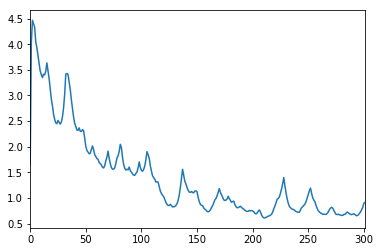

In [9]:
np.exp(pd.DataFrame(store_h)/2).mean().plot()
plt.show()

In [10]:
plt.figure(figsize=(20,25))
index=np.arange(0,15,3)
title=['mu','muh','phi','rhoh','omegah2']
for idx in range(len(index)):
    plt.subplot(5,3,1+index[idx])
    plt.plot(pd.DataFrame(store_theta)[idx])
    plt.title(title[idx])
    plt.xlabel('iteration')
    plt.subplot(5,3,1+index[idx]+1)
    plt.hist(pd.DataFrame(store_theta)[idx])
    ax1=plt.subplot(5,3,1+index[idx]+2)
    sm.graphics.tsa.plot_acf(pd.DataFrame(store_theta)[idx],lags=40,ax=ax1)
    plt.xlabel('lag')

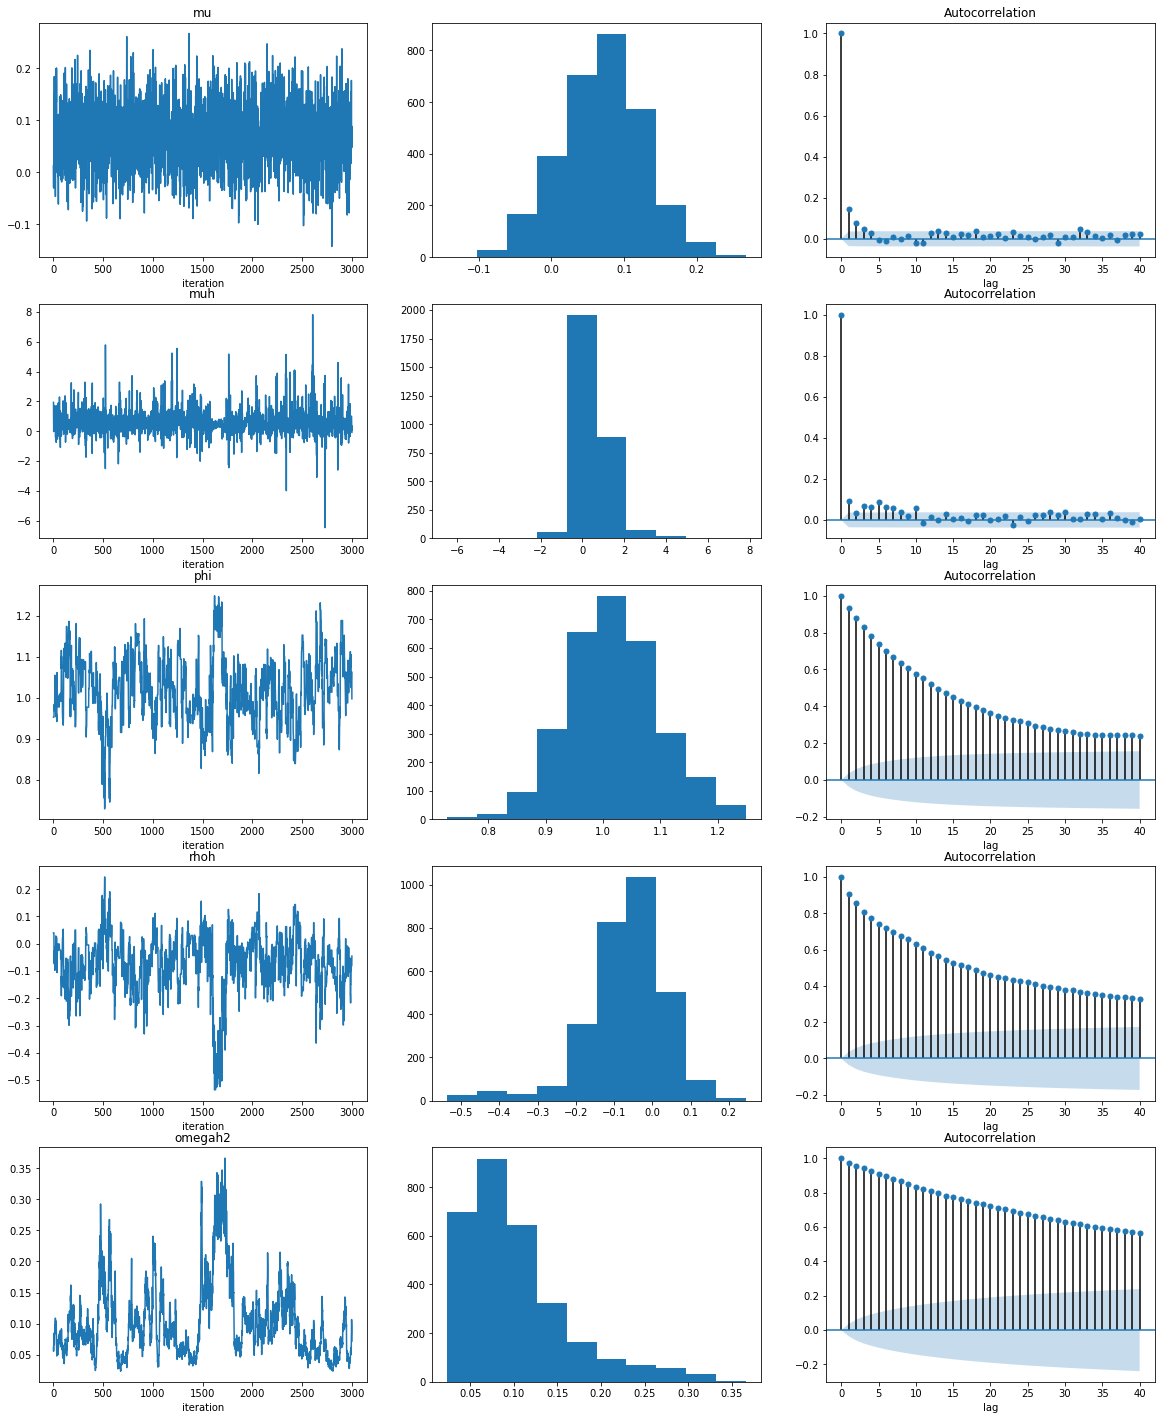

In [11]:
plt.show()

In [12]:
import csv
with open('C:\\Users\\wuboyuan\\Desktop\\结果\\sv2_h.csv', 'w') as f:
    #f.write(codecs.BOM_UTF8)
    writer = csv.writer(f,lineterminator='\n')
    writer.writerow(hs[M0+1:M0+M].T.index)
    writer.writerows(hs[M0+1:M0+M].values)

import csv
with open('C:\\Users\\wuboyuan\\Desktop\\结果\\sv2_theta.csv', 'w') as f:
    #f.write(codecs.BOM_UTF8)
    writer = csv.writer(f,lineterminator='\n')
    writer.writerow(ps[M0+1:M0+M].T.index)
    writer.writerows(ps[M0+1:M0+M].values)

NameError: name 'hs' is not defined